# KTR Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.ktrlite import KTRLiteMAP

from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components, plot_ktr_lev_knots
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
# load data
df = load_iclaims()

# define date and response column
date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [5]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.16888,-0.32831,0.11303,-0.45478,0.07173
1,2010-01-10,13.62422,0.16888,-0.20470,0.16433,-0.46263,0.05952
2,2010-01-17,13.39874,0.18514,-0.30233,0.11303,-0.50238,0.48141
3,2010-01-24,13.13755,0.15235,-0.20470,0.10245,-0.51890,0.37772
4,2010-01-31,13.19676,0.08335,-0.25232,0.07002,-0.52607,0.43648


### Train / Test Split

In [8]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [9]:
ktrlite = KTRLiteMAP(
    response_col='claims',
    date_col='week',
    # seasonality
    seasonality=52,
    seasonality_fs_order=5,
    level_knot_scale=.5,
    span_level=.1,
    span_coefficients=.3,
    rho_coefficients=.15,
    estimator_type=StanEstimatorMAP,
)

In [10]:
ktrlite.fit(train_df)

In [11]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52
0,2017-07-02,12.40007,12.37371,0.02636
1,2017-07-09,12.39214,12.37371,0.01843
2,2017-07-16,12.37149,12.37371,-0.00222
3,2017-07-23,12.34031,12.37371,-0.03341
4,2017-07-30,12.30210,12.37371,-0.07161


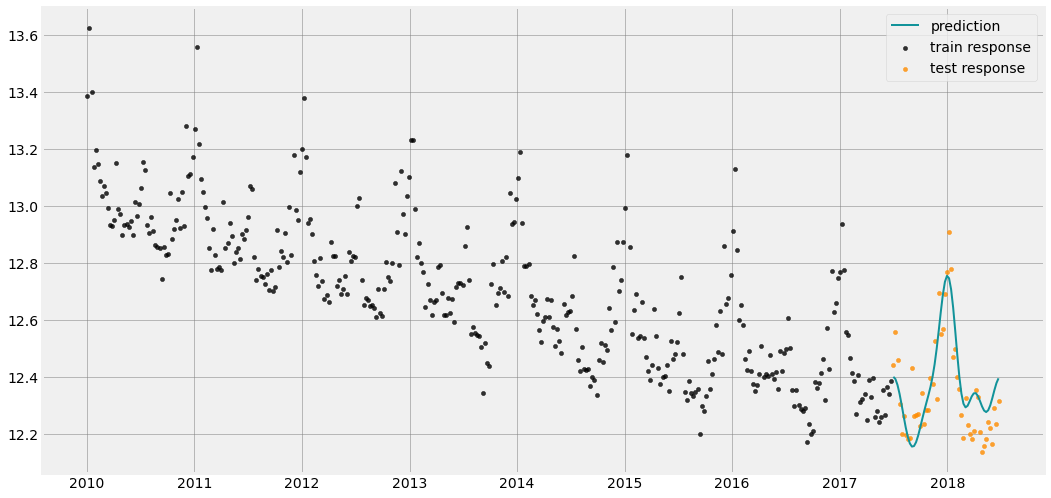

In [12]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [14]:
# get the knots
lev_knots = ktrlite._aggregate_posteriors['map']['lev_knot']
lev_knots_tp_discrete = ktrlite._knots_tp_level * train_df.shape[0] - 1
td = pd.Series([pd.Timedelta(weeks=k) for k in lev_knots_tp_discrete])
lev_knot_dates = train_df[date_col].iloc[0] + td

full_df = pd.concat((train_df, test_df), axis=0, ignore_index=True)
decomp_df = ktrlite.predict(df=full_df, decompose=True)

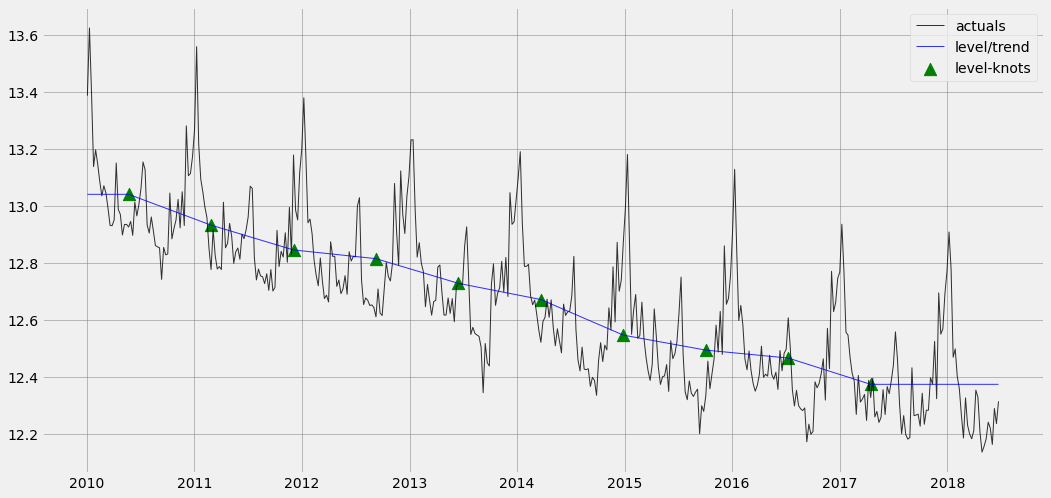

In [15]:
_ = plot_ktr_lev_knots(full_df, decomp_df, date_col, response_col, lev_knot_dates, lev_knots)